<a href="https://colab.research.google.com/github/lauren1turner/DS4002_LAM/blob/main/colorizing_gamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the GitHub Repo for the image files

In [1]:
!git clone https://github.com/lauren1turner/DS4002_LAM

Cloning into 'DS4002_LAM'...
remote: Enumerating objects: 1467, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 1467 (delta 89), reused 5 (delta 5), pack-reused 1301 (from 3)
Receiving objects: 100% (1467/1467), 73.46 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (700/700), done.


Import necessary libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets.folder import default_loader

Define the model and split training & testing data

In [11]:
class ImprovedColorizationModel(nn.Module):
    def __init__(self):
        super(ImprovedColorizationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [12]:
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

class ColorizationDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        color_image = Image.open(image_path).convert('RGB')
        grayscale_image = color_image.convert('L')

        if self.transform:
            color_image = self.transform(color_image)
            grayscale_image = self.transform(grayscale_image)

        return grayscale_image, color_image

# Define the transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Path to the images folder
image_folder_path = '/content/DS4002_LAM/PROJECT3/DATA/COLOR'
image_paths = [os.path.join(image_folder_path, fname) for fname in os.listdir(image_folder_path) if fname.endswith('jpg')]

# Split the data into training and testing sets (80/20)
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = ColorizationDataset(train_paths, transform=transform)
test_dataset = ColorizationDataset(test_paths, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


Training the model

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedColorizationModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_loader:
        grayscale_images, color_images = batch
        grayscale_images = grayscale_images.to(device)
        color_images = color_images.to(device)

        optimizer.zero_grad()
        outputs = model(grayscale_images)
        loss = criterion(outputs, color_images)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.0360
Epoch [2/10], Loss: 0.0208
Epoch [3/10], Loss: 0.0164
Epoch [4/10], Loss: 0.0122
Epoch [5/10], Loss: 0.0132
Epoch [6/10], Loss: 0.0149
Epoch [7/10], Loss: 0.0125
Epoch [8/10], Loss: 0.0084
Epoch [9/10], Loss: 0.0066
Epoch [10/10], Loss: 0.0157


Testing the model

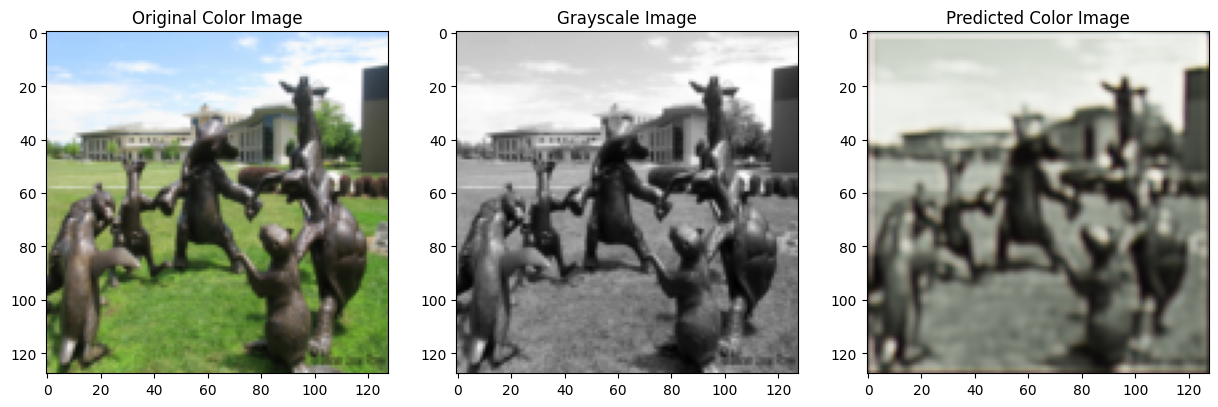

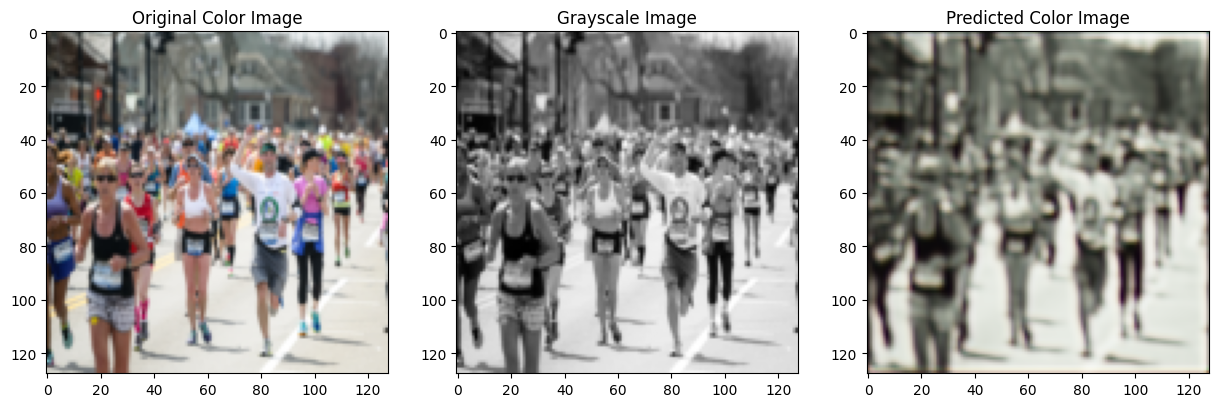

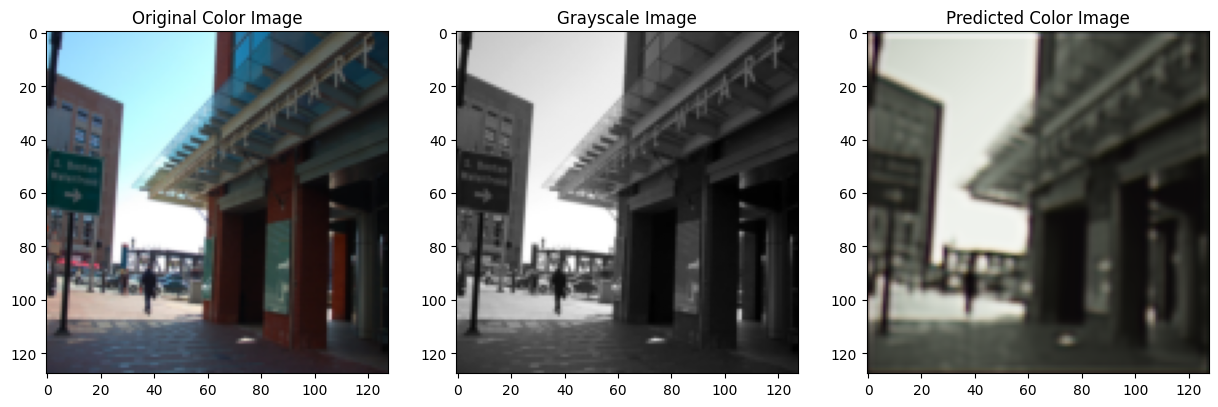

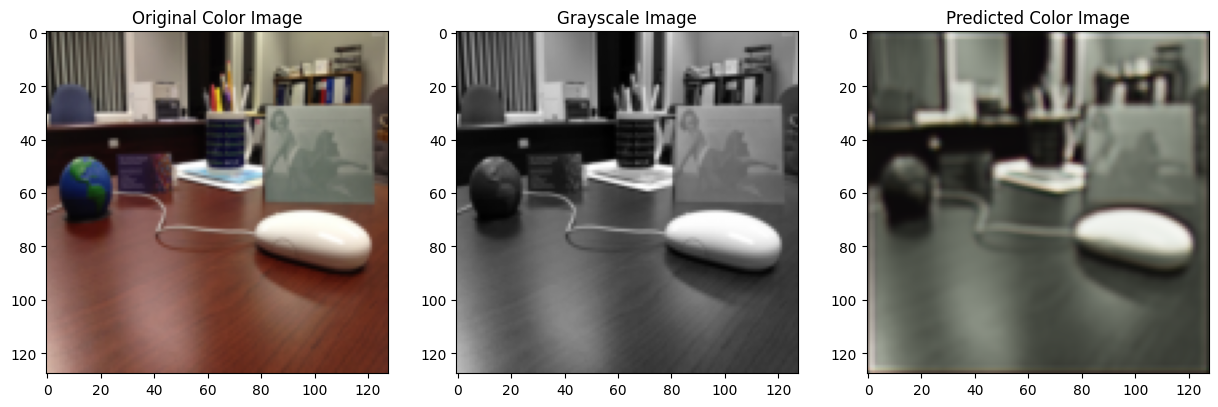

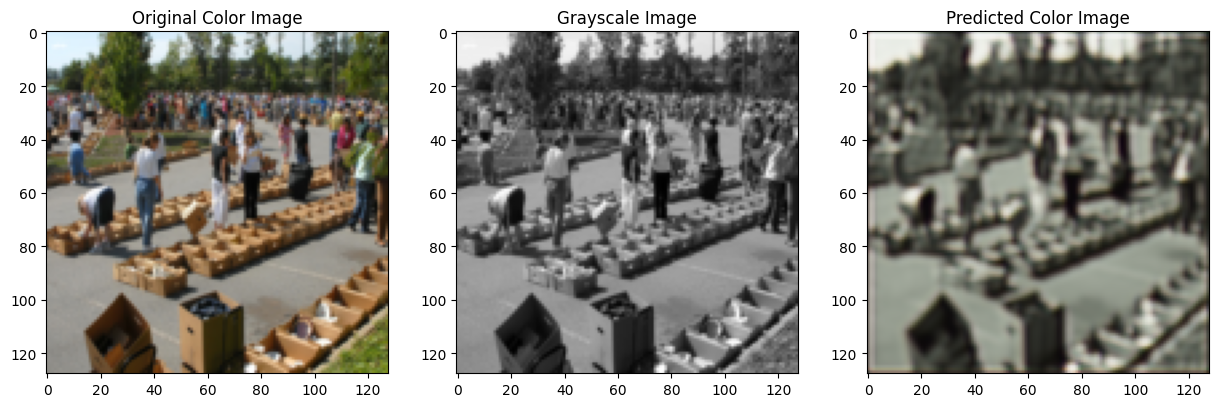

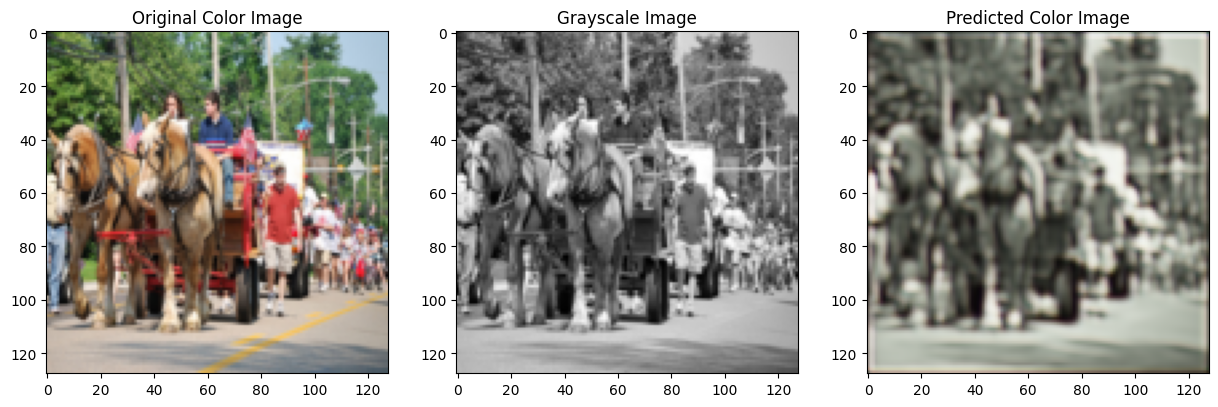

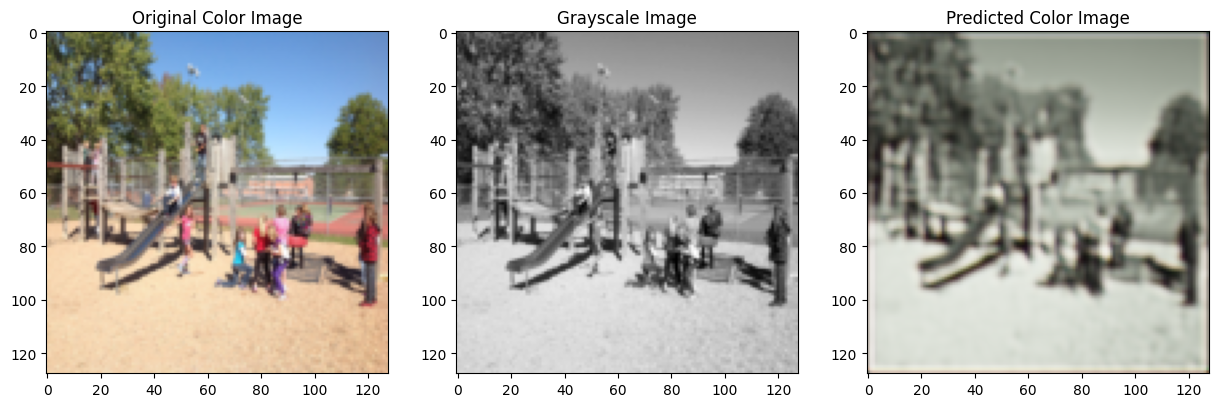

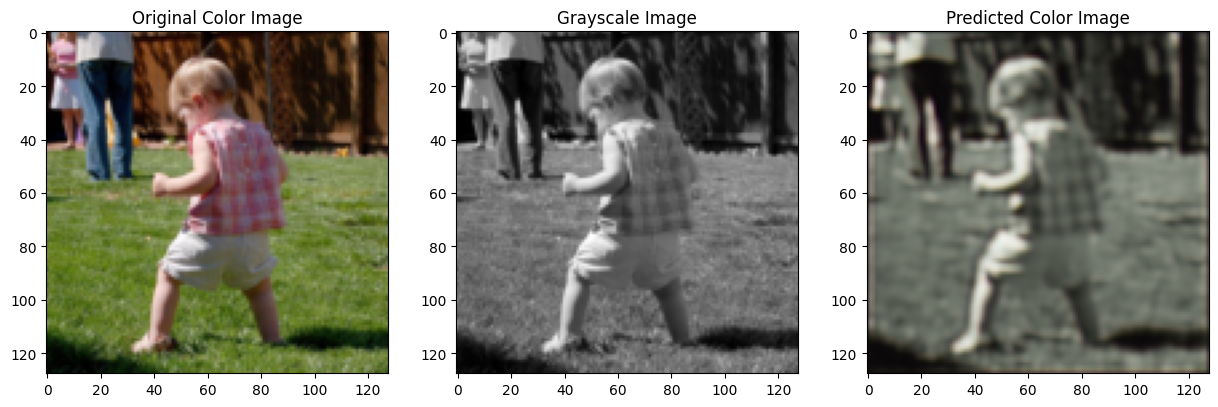

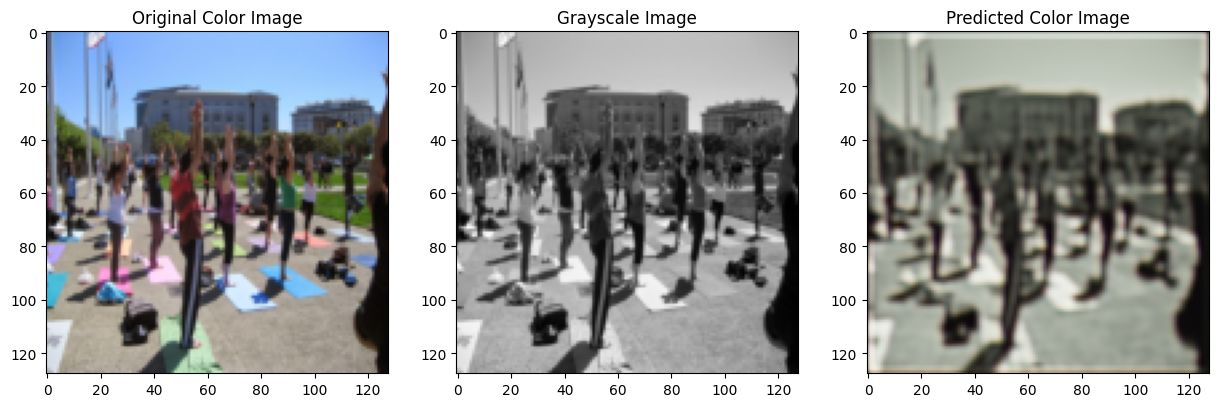

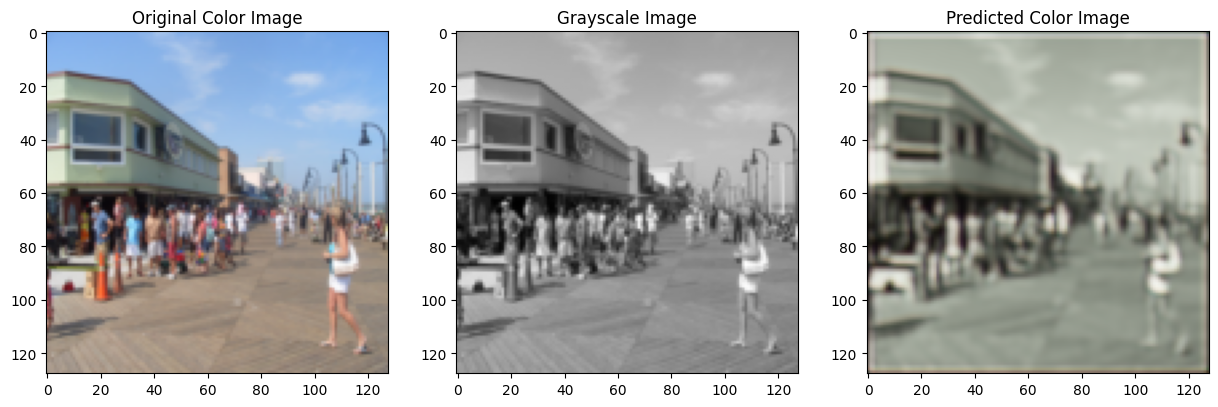

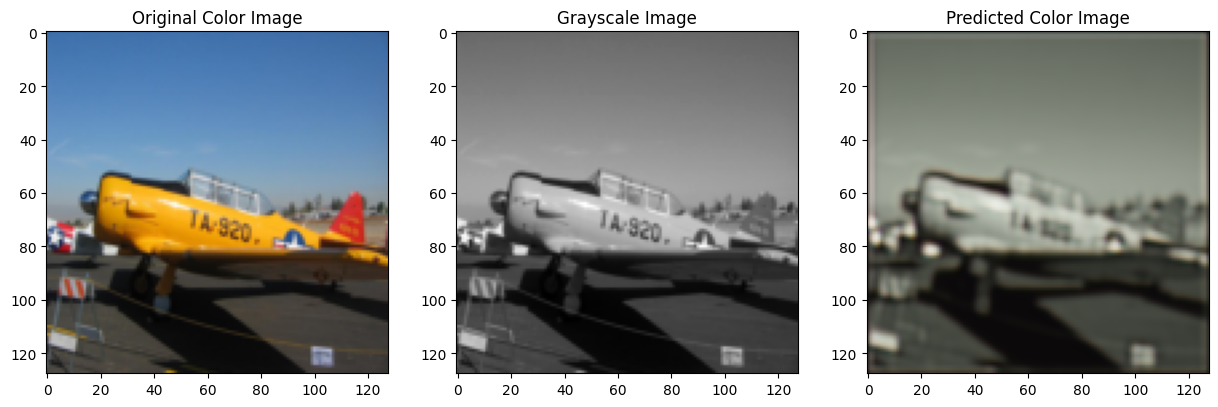

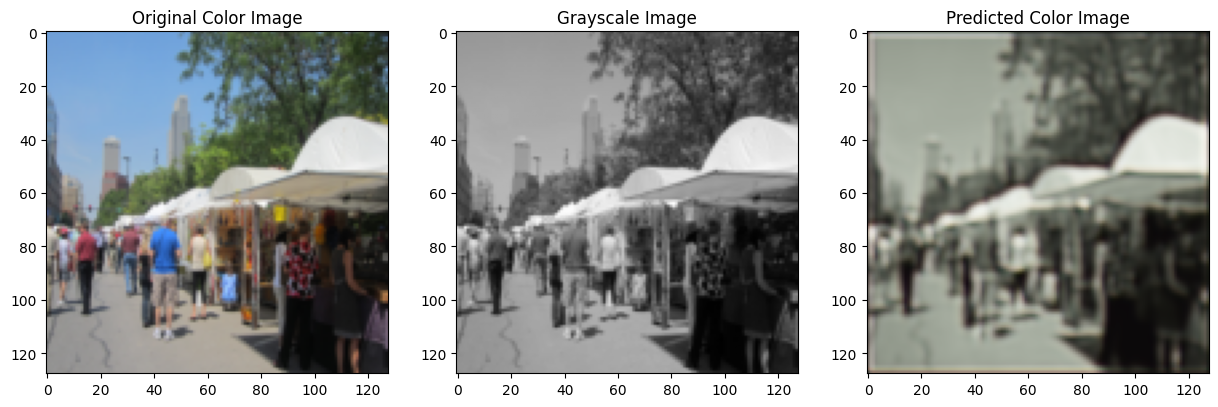

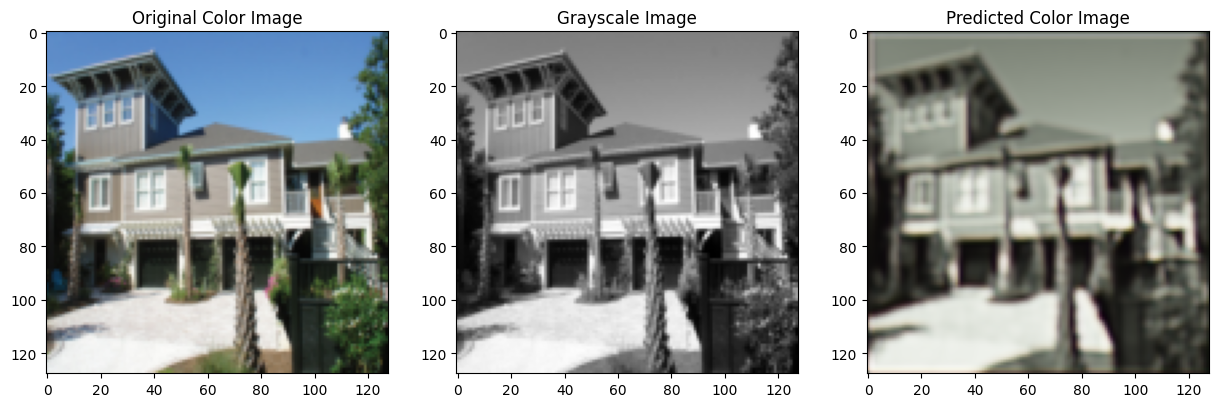

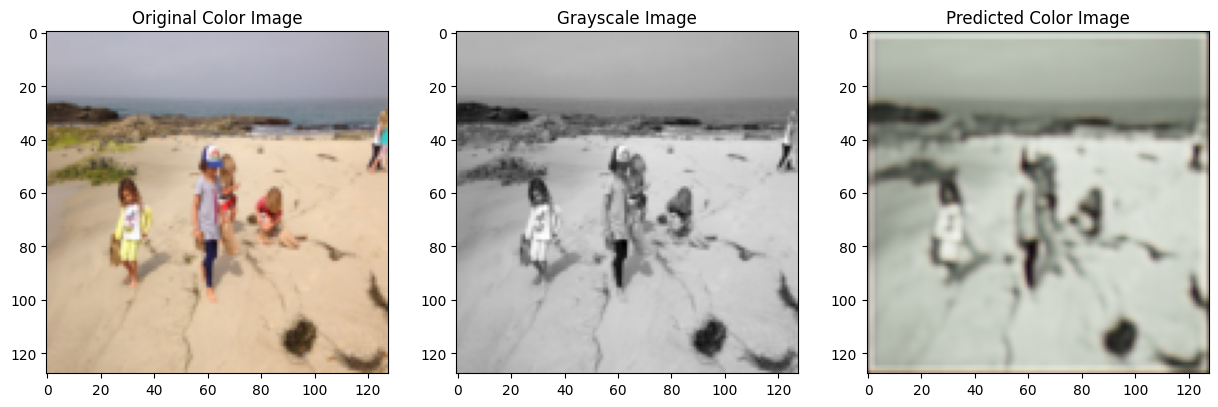

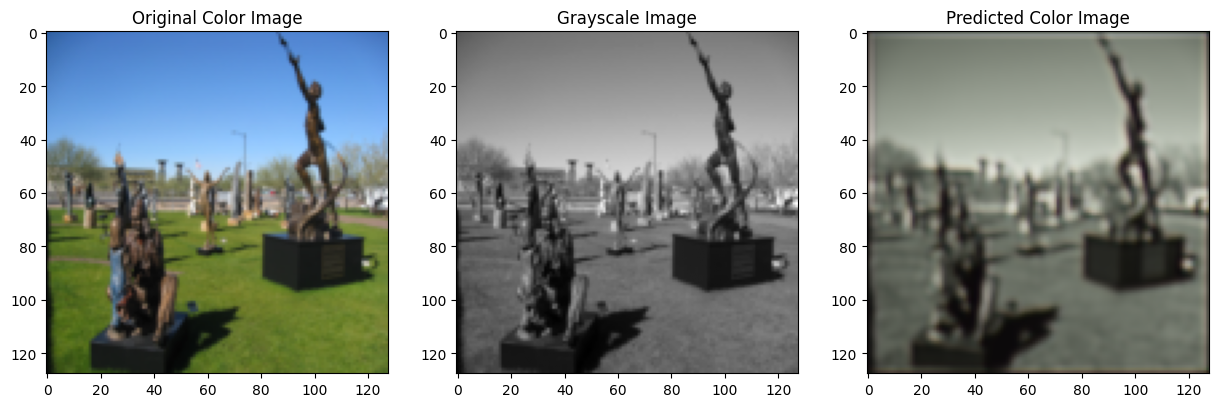

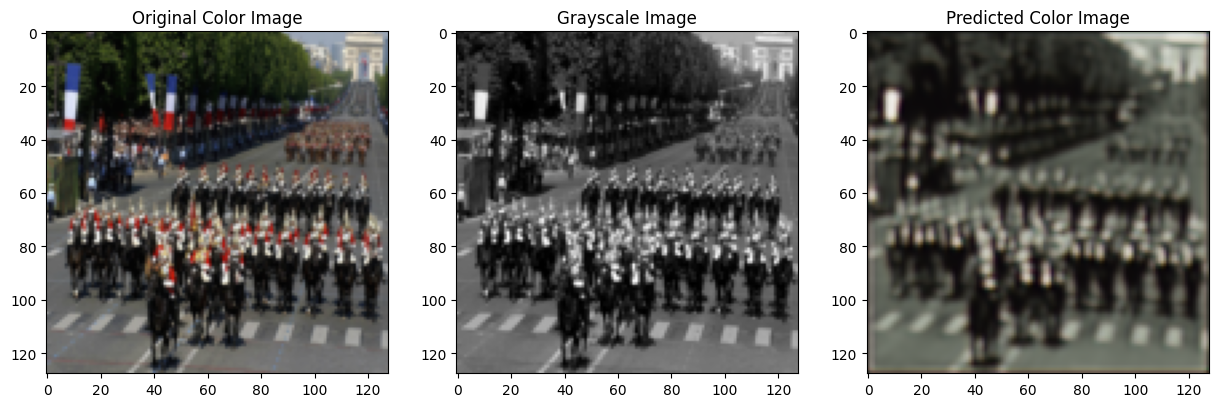

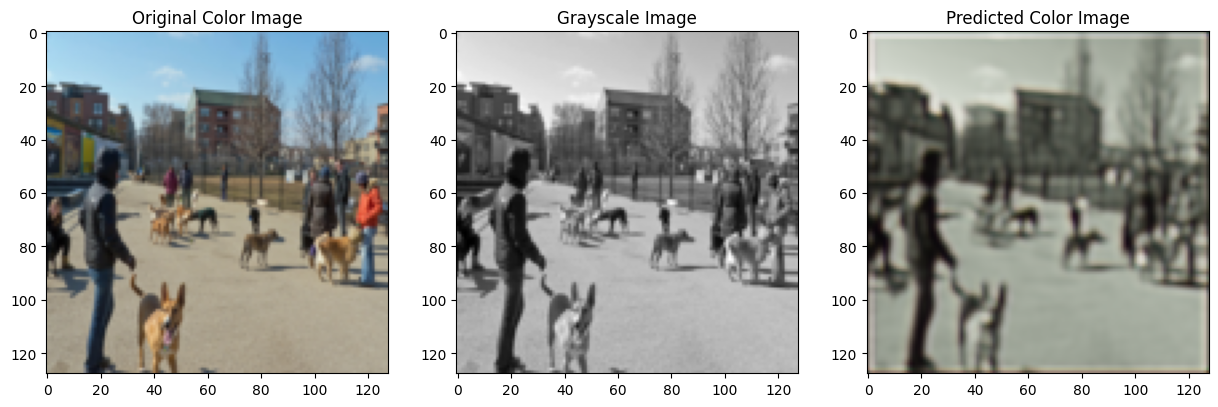

In [15]:
def test_model(model, test_loader):
    model.eval()
    for grayscale_image, color_image in test_loader:
        grayscale_image = grayscale_image.to(device)
        color_image = color_image.to(device)

        with torch.no_grad():
            output = model(grayscale_image)

        # Convert tensors to numpy arrays
        output_np = output.squeeze().cpu().numpy().transpose(1, 2, 0)
        grayscale_image_np = grayscale_image.squeeze().cpu().numpy()
        color_image_np = color_image.squeeze().cpu().numpy().transpose(1, 2, 0)

        # Ensure grayscale image has correct dimensions
        if len(grayscale_image_np.shape) == 2:
            grayscale_image_np = np.expand_dims(grayscale_image_np, axis=-1)

        # Display images side by side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(color_image_np)
        axes[0].set_title('Original Color Image')
        axes[1].imshow(grayscale_image_np, cmap='gray')
        axes[1].set_title('Grayscale Image')
        axes[2].imshow(output_np)
        axes[2].set_title('Predicted Color Image')
        plt.show()

# Test the model on the testing data
test_model(model, test_loader)
